# MCTS vs Minimax Comparative Analysis

This notebook contains code to conduct comparitive analysis of the performance of the MCTS and minimax agents.

We start by defining a function to generate random valid game boards. A valid game board has at least one free square available, and does not already have a winning line.

In [1]:
# Change working directory so imports work in Jupyter
import os
os.chdir("..")

import rules
import random
import numpy as np

def generate_random_board(min_moves=0, max_moves=8):
    """ Returns a random valid Tic Tac Toe game board with at least one move 
    remaining. """
    board = np.asarray([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    # Choose a starting player and game length
    side = random.choice([rules.CROSS, rules.NOUGHT])
    game_length = random.randint(min_moves, max_moves)

    # Select moves for each player until the game length has been reached
    move_count = 0
    while move_count < game_length:
        move_count += 1
        empty_cells = rules.empty_cells(board)
        move = tuple(empty_cells[random.randint(0, len(empty_cells) - 1)])
        board[move] = side
        if rules.winner(board):
            board[move] = rules.EMPTY
        else:
            side = -side

    # Return the game board and the side of the next player to move
    return board, side

## Single run

To compare the two agents, we generate a single board to test them against:

In [2]:
board, side = generate_random_board()
# board = np.asarray([[-1, -1, 0], [0, 0, 0], [0, 1, 0]])
# side = 1
print("Starting board ({} moves next):\n{}".format(
        rules.token(side), rules.board_str(board)))

Starting board (x moves next):
 | | 
o| | 
x| | 


Now we measure how long it takes the **minimax** agent to find the optimal moves for this game board:

In [3]:
import time
from agents.minimax import MiniMaxAgent

minimax_agent = MiniMaxAgent()
minimax_agent.side = side

t = time.time()
_, minimax_moves = minimax_agent.minimax(board, minimax_agent.side)
minimax_time = round(time.time() - t, 6)

print "Minimax time:", minimax_time

Minimax time: 0.272


Then we measure how long it takes the **MCTS** agent to find the optimal moves for the same game board:

In [4]:
from agents.mcts_ucb1 import MCTSAgentUCB1, UCTTreeNode

max_iterations = 2 * len(rules.empty_cells(board))**2  # the square of the number of free cells
print "Convergence limit:", max_iterations
mcts_agent = MCTSAgentUCB1(convergence_limit=max_iterations)
mcts_agent.side = side

t = time.time()
mcts_moves = mcts_agent.moves(board)
mcts_time = round(time.time() - t, 6)

print "Number of MCTS playouts:", mcts_agent.playout_count

print "\nMCTS time:", mcts_time

Convergence limit: 98
Number of MCTS playouts: 147

MCTS time: 0.044


The convergence limit is used to stop the MCTS algorithm after a certain number of iterations. If the selected move has not changed in `max_iterations`, then the algorithm stops and that move is returned. This limit is set based on the square of the number of moves remaining. It might be better to look at the most frequent action over a sample of iterations, and measure how long since it has changed.

We can display a graph of the game tree generated by the MCTS agent to help visualise where the search ended:

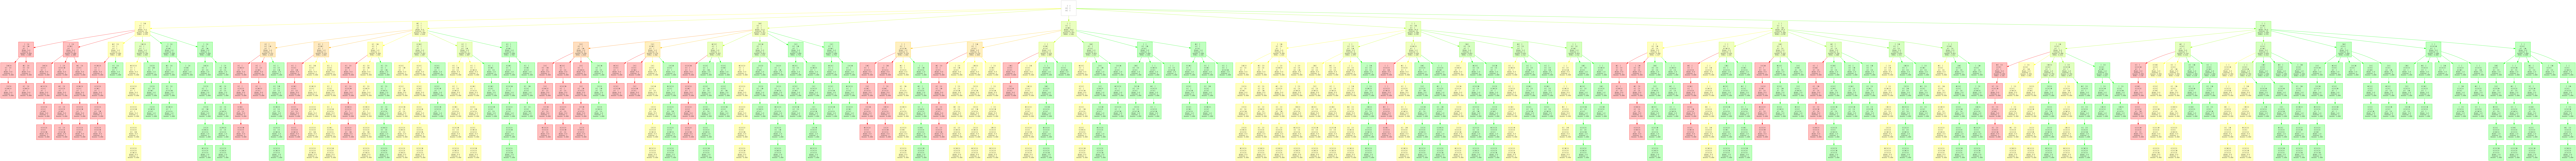

In [5]:
from IPython.display import display_png
import pygraphviz as pgv
from graphing.mcts_graph import MCTSGraph

g = MCTSGraph()
#g.verbose_score = False
a = g.generate_graph(mcts_agent.root_node)

display_png(g.draw_graph(format='png'), raw=True)

Finally we compare the time taken by each agent to find the optimal move/s.

In [6]:
print("Minimax optimal moves: {}\nMCTS optimal moves: {}".format(minimax_moves.tolist(), mcts_moves))

print("\nTime to calculate optimal move {}:\n  Minimax\t{} s\n  MCTS\t\t{} s".format(mcts_moves, minimax_time, mcts_time))

Minimax optimal moves: [[1, 1], [2, 1], [2, 2]]
MCTS optimal moves: [(1, 1)]

Time to calculate optimal move [(1, 1)]:
  Minimax	0.272 s
  MCTS		0.044 s


## Batch run

Next we gather results from a number of games, to compare the agents against different numbers of available actions.

For each run, a random game board is generated and the time taken for each agent to find an optimal move is recorded against the number of actions that were available.

The time taken by the minimax agent is expected to increase significantly faster than by the MCTS agent.

In [7]:
# Results in the format {n_actions:[list_of_time]}
minimax_results = {}
mcts_results = {}
num_games = 10
count = 0

while count < num_games:
    count += 1
    
    board, side = generate_random_board(min_moves=0)
    n_actions = len(rules.empty_cells(board))
    
    # Time the minimax agent
    minimax_agent.side = side
    t = time.time()
    _, minimax_moves = minimax_agent.minimax(board, minimax_agent.side)
    minimax_time = round(time.time() - t, 6)
    minimax_results.setdefault(n_actions, []).append(minimax_time)

    # Time the MCTS agent
    max_iterations = 2 * n_actions**2  # the square of the number of free cells
    mcts_agent.convergence_limit = max_iterations
    mcts_agent.side = side
    t = time.time()
    mcts_moves = mcts_agent.moves(board)
    mcts_time = round(time.time() - t, 6)
    mcts_results.setdefault(n_actions, []).append(mcts_time)
       
# Display the mean time to find the optimal move for each agent
minimax_means = {}
for n_actions in minimax_results.keys():
    minimax_means[n_actions] = round(sum(minimax_results[n_actions]) / len(minimax_results[n_actions]), 4)
mcts_means = {}
for n_actions in mcts_results.keys():
    mcts_means[n_actions] = round(sum(mcts_results[n_actions]) / len(mcts_results[n_actions]), 4)
    
print "{:<8} {:<18} {:<15}\n----------------------------------------".format('Moves', 'Minimax average', 'MCTS average')
for n_actions in minimax_means.keys():
    print "{:<8} {:<18} {:<15}".format(n_actions, minimax_means[n_actions], mcts_means[n_actions])

Moves    Minimax average    MCTS average   
----------------------------------------
1        0.0                0.0            
3        0.0003             0.002          
5        0.009              0.012          
7        0.28               0.09           
8        3.7255             0.191          
9        17.3945            0.131          


To better visualise the results we can graph the performance of each agent against the number of actions available, including trendlines to show the averages.

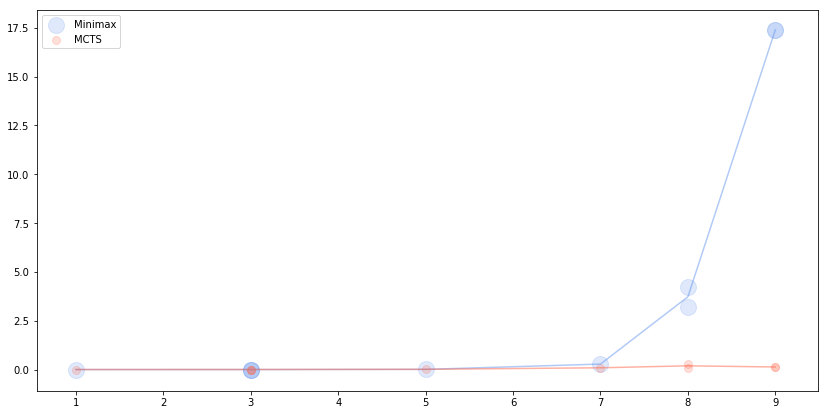

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 7]

x = minimax_results.keys()
y = minimax_results.values()
for xe, ye in zip(x, y):
    minimax_line = plt.scatter(label='Minimax', x=[xe] * len(ye), y=ye, marker='o', s=256, color='cornflowerblue', alpha=0.2)
# Plot the means as a trendline
plt.plot(minimax_means.keys(), minimax_means.values(), color='cornflowerblue', alpha=0.5)
    
x = mcts_results.keys()
y = mcts_results.values()
for xe, ye in zip(x, y):
    mcts_line = plt.scatter(label='MCTS', x=[xe] * len(ye), y=ye, marker='.', s=256, color='tomato', alpha=0.2)
# Plot the means as a trendline
plt.plot(mcts_means.keys(), mcts_means.values(), color='tomato', alpha=0.5)

plt.legend(handles=[minimax_line, mcts_line])
    
plt.show()

The graph shows that, as expected, the minimax agent takes exponentially more time to find the optimal moves as the number of actions available to it increases.

The MCTS agent takes longer for lower numbers of actions, however this is likely a result of the convergence test.